# Doing MachineLearning classification for DeepSky Datasets(Kepler)

In [8]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn import svm
import matplotlib.pyplot as plt
import scipy.optimize as opt
import glob
import os
import sys
from astropy.io import fits
%matplotlib inline

In [9]:
#sys.modules[__name__].__dict__.clear()
#Utility function to read the files and put in the pandas dataframe



def readData(path):
    allFiles = glob.glob(path)
    list_ = []
    df_ = pd.DataFrame()
    totalFile = 0
    readFile = 0
    
    for file_ in allFiles:
        #print file_
        dataList = fits.open(file_)
        
        totalFile = totalFile+1
        #flux = np.array(dataList[0].data[0],float) #flux
        #wavelength = np.array(dataList[0].data[1],float) #wavelength
        
        df = pd.DataFrame(np.array(dataList[0].data,float)).transpose() #Making sure the data format is right.        
        df = df.dropna(axis=0)
        #print np.unique(df.isnull())
        #print df.isnull().values.any()
              
        #If length of the file is greater than 3000, only include that
        if(df.shape[0] > 3000):
            #print file_
            readFile = readFile+1
            list_.append(df.values.flatten()[0:3000])
        #df_ = df_.append(df.values.flatten())
    
    print 'Total File', totalFile
    print 'Read File', readFile
    return pd.DataFrame(list_)

In [10]:
#Give the path and it will read all the files with .fits extension in dataframe.




path1 = r'/home/shared/Kepler/kepler_simtran_3d4hr_nokoi/*.fits' #Signal
path2 = r'/home/shared/Kepler/kepler_0021_orig_nokoi/*.fits'#no signal

#path1 = r'/home/rbhat/S3Lab Project/Kepler-Astronomy/SubsetData/kepler_simtran_3d4hr_nokoi-Signal/*.fits' #Signal
#path2 = r'/home/rbhat/S3Lab Project/Kepler-Astronomy/SubsetData/kepler_0021_orig_noki-No-Signal/*.fits'   #No-Signal

print 'Read for frame1'
frame1 = readData(path1) #Signal
print 'Read for frame2'
frame2 = readData(path2) #No-Signal

Read for frame1
Total File 6929
Read File 6024
Read for frame2
Total File 6929
Read File 6024


In [15]:
#Making sure the dataframe size match with the expected..
print frame1.shape, frame2.shape 

#print frame1.head

(6024, 3000) (6024, 3000)


Plot the figure. Since the arrays are flatten, I am taking individual flux and time accordingly to plot the figure.

(3000,) (3000,)
1500 1500
1500 1500


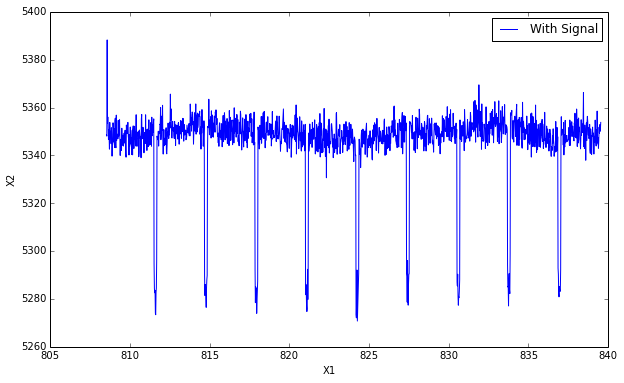

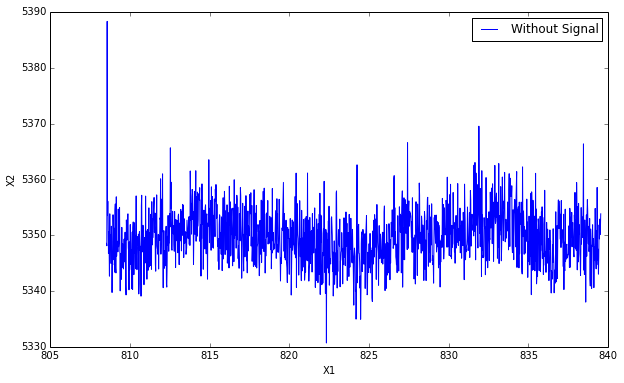

In [28]:
#Plotting the figure
n_start = 0
n_end = 3000

n = 0 #First row of the dataframe.

frame1_tmp = frame1.loc[n,:]  #1st signal
frame2_tmp = frame2.loc[n,:]  #1st signal

print frame1_tmp.shape, frame2_tmp.shape

frame1_tmp_x = [val for i,val in enumerate(frame1_tmp) if (i%2 == 0)]
frame1_tmp_y = [val for i,val in enumerate(frame1_tmp) if (i%2 != 0)]

frame2_tmp_x = [val for i,val in enumerate(frame2_tmp) if (i%2 == 0)]
frame2_tmp_y = [val for i,val in enumerate(frame2_tmp) if (i%2 != 0)]

#frame1_tmp_x = frame1_tmp_x
print len(frame1_tmp_x), len(frame1_tmp_y)

#frame2_tmp_x = frame2_tmp_x
print len(frame2_tmp_x), len(frame2_tmp_y)

#print frame2_tmp_y

#print frame1_tmp

for i in [0,1]:
    fig, ax = plt.subplots(figsize=(10,6))
    if i == 0:
        ax.plot(frame1_tmp_x, frame1_tmp_y, label='With Signal')
    else:
        ax.plot(frame2_tmp_x, frame2_tmp_y, label='Without Signal')
    #ax.scatter(frame1_tmp[0], frame1_tmp[1], s=30, marker='x', label='With Signal')
    #ax.scatter(frame2_tmp[0], frame2_tmp[1], s=30, marker='o', label='Without Signal')
    ax.legend()
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    #ax.set_ylim([458000,467000])
    #fig.suptitle(i)


In [29]:
#Make both frame into one and assign signal and non-signal label as 1 & 0. 
print frame1.shape, frame2.shape

frame1_Y1 = np.ones((frame1.shape[0],1))
frame1['Y'] = frame1_Y1

frame2_Y2 = np.zeros((frame2.shape[0],1))
frame2['Y'] = frame2_Y2

#print Y1.shape
#print frame1.head()
print frame1.shape, frame2.shape
#print frame1_Y1
#print frame2_Y2

(6024, 3000) (6024, 3000)
(6024, 3001) (6024, 3001)


In [30]:
#Combine 2 data frame and reshuffle the data randomly
#ignore_index=True will make sure it will index serially.
frame = pd.concat([frame1, frame2], ignore_index=True)

#Reshuffle the data randomly
frame = frame.reindex(np.random.permutation(frame.index))
#frame.reset_index()

print frame.shape
#print frame.head()
#print frame.loc[0:5,2990:] 
print frame['Y'][0:5] 

(12048, 3001)
5229     1
10017    0
7395     0
9212     0
11826    0
Name: Y, dtype: float64


In [31]:
#Splitting the data for classification purpose..
#Input dataframe consists of X1, X2
#print frame.shape
#print frame.iloc[:,9273:]
X = frame.drop(['Y'],axis=1) 
#print X.iloc[:,9273:]

print X.shape

#Output vector(predictor/response) vector
Y = frame['Y']

print Y.shape
#Splitting data into train and testing. 70% Training and 30% Testing..
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=4)

(12048, 3000)
(12048,)


In [32]:
print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

#Validating the number
#print 101390*0.7, 101390*0.3 

(8433, 3000) (8433,) (3615, 3000) (3615,)


## Logistic Regression

In [33]:
#Logistic Regression-sklearn
logReg = LogisticRegression()
logReg.fit(X_train,Y_train)
Y_logPred = logReg.predict(X_test)
print metrics.accuracy_score(Y_test,Y_logPred)

0.995573997234


[[1771   12]
 [   4 1828]]


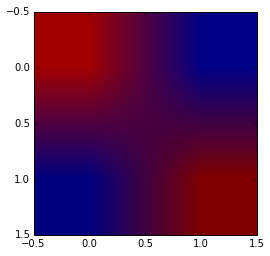

In [34]:
#Confusion matrix of logistic regression
conf = metrics.confusion_matrix(Y_test,Y_logPred)
plt.imshow(conf)
print conf

## KNeighbours

In [35]:
# KNeighbours classification
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train,Y_train)
Y_pred = knn.predict(X_test)
print metrics.accuracy_score(Y_test, Y_pred)
conf = metrics.confusion_matrix(Y_test, Y_pred)
#plt.imshow(conf)
print conf

0.410235131397
[[ 954  829]
 [1303  529]]


## Random Forest

In [36]:
#Random Forest Classification
randForest = RandomForestClassifier(n_estimators=30)
randForest.fit(X_train,Y_train)
Y_randForestPred = randForest.predict(X_test)
print metrics.accuracy_score(Y_test,Y_randForestPred)

0.588105117566


In [37]:
#Confusion matrix for randomforest
conf2 = metrics.confusion_matrix(Y_test,Y_randForestPred)
#plt.imshow(conf2)
print conf2

[[1147  636]
 [ 853  979]]


## Support Vector machine

In [38]:
#Support Vector Machine
svc = svm.LinearSVC(C=10, loss='hinge', max_iter=1000)
svc

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [39]:
svc.fit(X_train,Y_train)
svc.score(X_test, Y_test)

0.96071922544951593